In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import sklearn, sklearn.metrics

import glob
import captum
import latentshift
import classifiers
import ct_models
import ct_datasets
import skimage

/tmp/ipykernel_162134/958535668.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = classifiers.phecode.PheCodeClassifier().to(device)

Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
weights_path = '/home/groups/akshaysc/joecohen/weights/'
ae_folder = '2023-07-27T19-35-51_ct_vqgan_sdd'
ae_folder = '2023-12-25T10-26-40_ct2_vqgan256_sddd'
ae = ct_models.VQGAN(
    ckpt_path=f'{weights_path}/{ae_folder}/checkpoints/last.ckpt',
    yaml_path=glob.glob(f'{weights_path}/{ae_folder}/configs/*-project.yaml')[0],
    resize=256,
).to(device)

Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
!ls /home/users/joecohen/group/phecode_scans/pacemaker/

AC423c71a_0000.nii.gz  AC4240355_0000.nii.gz  AC4242a48_0000.nii.gz
AC423d550_0000.nii.gz  AC4240711_0000.nii.gz  AC424343e_0000.nii.gz
AC423efff_0000.nii.gz  AC42409a7_0000.nii.gz  isolated_scans.zip
AC4240174_0000.nii.gz  AC4240d86_0000.nii.gz  __MACOSX


In [7]:
data = ct_datasets.NIFTI_Dataset('/home/users/joecohen/group/phecode_scans/pain_cases/', 
                                resolution=224)

In [18]:
img = data[1]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 152])

In [19]:
img.min(), img.max()

(metatensor(0.), metatensor(1.))

In [20]:
# for i in range(5):
#     sample = data[i]
#     img = sample['image'][None,...]
#     with torch.no_grad():
#         o = model(img.cuda()).cpu()
#     print(i, os.path.basename(sample['image_path']))

#     for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'pacemaker' in target]:
#         print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

In [21]:
# for i in range(10):
#     sample = data[i]
#     img = sample['image'][None,...]
#     with torch.no_grad():
#         o = model(img.cuda())
#     print(i, os.path.basename(sample['image_path']))
#     topk = o.topk(10)
#     for val, ind in zip(topk.values.cpu().numpy()[0], topk.indices.cpu().numpy()[0]):
#         print("   " + str(val) + "  " + model.targets[ind])

In [22]:
# ae2 = ct_models.SliceAEFull(ae, 0, 0)
# for i in range(2):
#     sample = data[i]
#     img = sample['image'][None,...]

#     with torch.no_grad():
#         imgp = ae2.decode(ae2.encode(img.cuda()))
#         o = model(imgp)
#     print(i, os.path.basename(sample['image_path']))
#     topk = o.topk(10)
#     for val, ind in zip(topk.values.cpu().numpy()[0], topk.indices.cpu().numpy()[0]):
#         print("   " + str(val) + "  " + model.targets[ind])

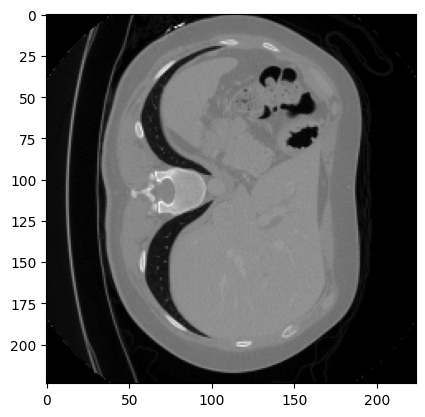

In [24]:
plt.imshow(img[0,0,:,:,122], cmap='gray');

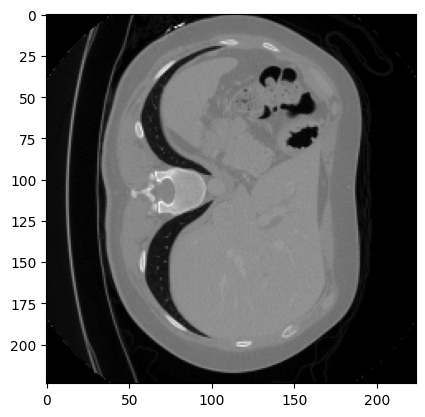

In [25]:
x = img[:,:,:,:,122]
#x = torch.from_numpy(ct_datasets.Resize(256)(x[0,0])[None,None])
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [26]:
z = ae.encode(x.cuda())

In [27]:
img2 = ae.decode(z)

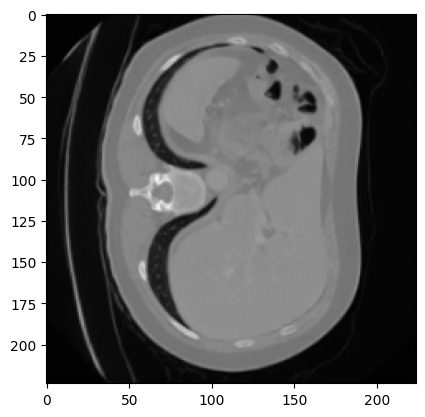

In [28]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [30]:
[(i, target) for i, target in enumerate(model.targets) if 'pain' in target]


[(506, 'Acute pain'),
 (507, 'Chronic pain'),
 (544, 'Complex regional/central pain syndrome'),
 (545, 'Chronic pain syndrome'),
 (702, 'Nonspecific chest pain'),
 (703, 'Precordial pain'),
 (844, 'Throat pain'),
 (1491, 'Back pain'),
 (1517, 'Abdominal pain')]

In [31]:
[(i, target) for i, target in enumerate(model.targets) if 'pace' in target]


[(421,
  'Swelling, mass, or lump in head and neck [Space-occupying lesion, intracranial NOS]'),
 (727, 'Cardiac pacemaker/device in situ'),
 (728, 'Cardiac pacemaker in situ')]

In [123]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
        model, 
        target='Abdominal pain', 
        #adjustment=lambda x: x+8,
        rename_model='', sigmoid=False), 
    ct_models.SliceAEFull(ae, 120,130),
)
output = attr.attribute(img.cuda(), target=0,
                        #fix_range=[-1800,0], 
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 20000,
                       )[0]
#plt.imshow(output['heatmap'][0]);

Shift: 0, Pred: 0.5332621335983276, pixel_diff: 0.0, sum*diff_pct: 149640.828125
Shift: -10.0, Pred: 0.5325117111206055, pixel_diff: 14.404703140258789, sum*diff_pct: 149640.828125
Shift: -21.0, Pred: 0.5317561626434326, pixel_diff: 30.23084259033203, sum*diff_pct: 149640.828125
Shift: -34.0, Pred: 0.5310722589492798, pixel_diff: 48.85620880126953, sum*diff_pct: 149640.828125
Shift: -48.0, Pred: 0.5304369926452637, pixel_diff: 68.86798095703125, sum*diff_pct: 149640.828125
Shift: -63.0, Pred: 0.5299204587936401, pixel_diff: 90.27751159667969, sum*diff_pct: 149640.828125
Shift: -80.0, Pred: 0.5294484496116638, pixel_diff: 114.43301391601562, sum*diff_pct: 149640.828125
Shift: -98.0, Pred: 0.5288715362548828, pixel_diff: 139.9346466064453, sum*diff_pct: 149640.828125
Shift: -118.0, Pred: 0.5283182859420776, pixel_diff: 168.1748046875, sum*diff_pct: 149640.828125
Shift: -140.0, Pred: 0.527744710445404, pixel_diff: 199.15066528320312, sum*diff_pct: 149640.828125
Shift: -164.0, Pred: 0.5272

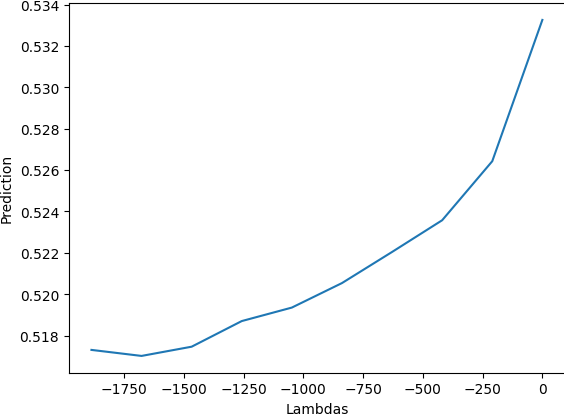

In [124]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

In [147]:
outputs[12]['preds']

[0.5173048973083496, 0.5332621335983276]

In [143]:
single_diffs = np.abs(output['heatmap']**2).sum(0).sum(0).sum(0)

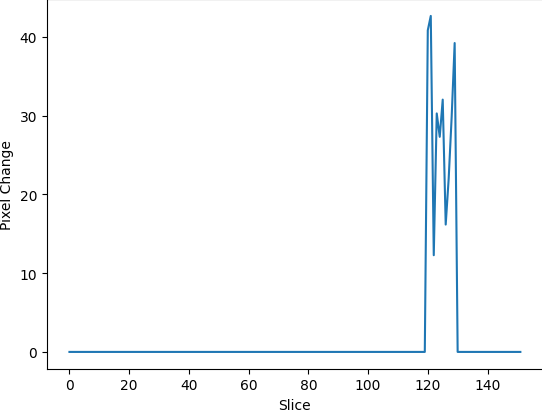

In [141]:
plt.plot(single_diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [138]:
output['heatmap'].shape

(1, 224, 224, 152)

In [139]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

121

In [129]:
idx = 120

In [152]:
plt.imshow(output['heatmap'][0,:,:,idx]**2);

In [131]:
images = [output['generated_images'][i, :,:,:,idx] for i in range(len(output['generated_images']))]

In [132]:
images[0].shape

(1, 224, 224)

In [133]:
np.asarray(images).mean((1,2,3))

array([0.3988022 , 0.39883575, 0.398864  , 0.39888802, 0.3988829 ,
       0.39886403, 0.39883274, 0.3987753 , 0.3986857 , 0.3985817 ],
      dtype=float32)

In [134]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':output['preds']}, "test", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=0,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=      25kB time=00:00:00.76 bitrate= 273.9kbits/s speed= 3.5x    


In [57]:
outputs = []
batch_size = 10
for i in tqdm(range(0, img.shape[-1], batch_size)):
    print(f'Slices {i}-{i+batch_size}')
    attr = captum.attr.LatentShift(
        latentshift.alignment.ModelWrapper(
            model, 
            target='Abdominal pain',
            #adjustment=lambda x: x+8, 
            rename_model='', sigmoid=False),
        ct_models.SliceAEFull(ae, i, i+batch_size)
    )
    output = attr.attribute(img.cuda(), target=0,
                            #fix_range=[-700,0],
                            return_dicts = True,
                            apply_sigmoid = False,
                            lambda_sweep_steps = 2,
                            search_max_steps = 20000,
                            verbose=False,
                           )[0]
    outputs.append(output)

  0%|          | 0/16 [00:00<?, ?it/s]

Slices 0-10
Slices 10-20
Slices 20-30
Slices 30-40
Slices 40-50
Slices 50-60
Slices 60-70
Slices 70-80
Slices 80-90
Slices 90-100
Slices 100-110
Slices 110-120
Slices 120-130
Slices 130-140
Slices 140-150
Slices 150-160


In [58]:
len(outputs)

16

In [59]:
pred_changes = np.concatenate([[np.min(o['preds'])]*batch_size for o in outputs])

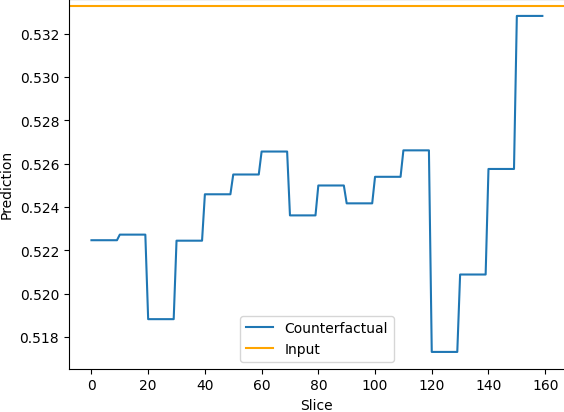

In [60]:
plt.plot(pred_changes, label='Counterfactual');
plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')
plt.xlabel('Slice');
plt.ylabel('Prediction');
plt.legend();

In [61]:
heatmaps = np.concatenate([o['heatmap'] for o in outputs], 3)

In [62]:
raw_diffs = np.concatenate([np.abs(o['heatmap']**2).sum(0).sum(0).sum(0) for o in outputs])
diffs = raw_diffs[raw_diffs != 0]

In [106]:
heatmaps1 = heatmaps[:,:,:,raw_diffs != 0]
images_reconstruction = np.concatenate([o['generated_images'][-1] for o in outputs], 3)
images_counterfactual = np.concatenate([o['generated_images'][0] for o in outputs], 3)

In [107]:
images_reconstruction = images_reconstruction[...,raw_diffs != 0]
images_counterfactual = images_counterfactual[...,raw_diffs != 0]

In [108]:
images_reconstruction = [skimage.transform.rotate(img,90) for img in images_reconstruction]
images_counterfactual = [skimage.transform.rotate(img,90) for img in images_counterfactual]
heatmaps1 = [skimage.transform.rotate(img,90) for img in heatmaps1]

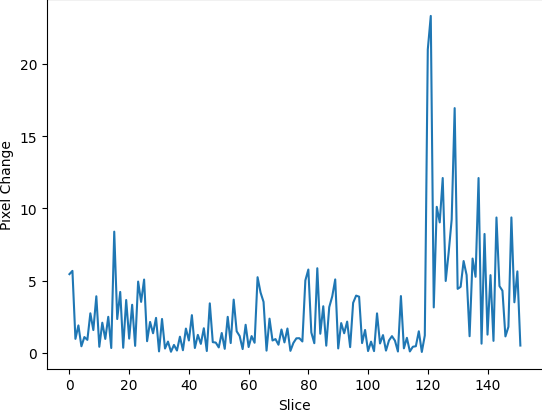

In [98]:
plt.plot(diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

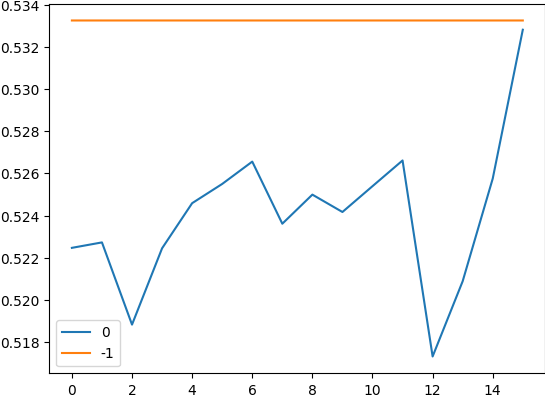

In [99]:
plt.plot([output['preds'][0] for output in outputs], label='0')
plt.plot([output['preds'][-1] for output in outputs], label='-1')
plt.legend();

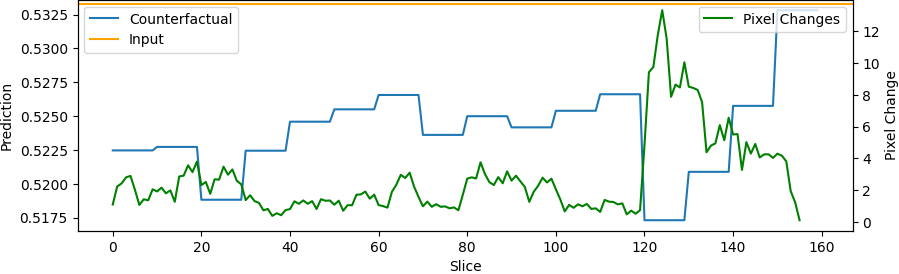

In [100]:
plt.figure(figsize=(10,3))
lines = []
lines.append(plt.plot(pred_changes, label='Counterfactual'))
lines.append([plt.axhline(outputs[0]['preds'][-1], label='Input', c='orange')])
plt.ylabel('Prediction');
plt.legend(loc='upper left')
plt.xlabel('Slice');
plt.twinx()
xnew = np.linspace(0, len(diffs), len(diffs)) 
smoothed_diffs = np.convolve(diffs, np.ones(5)/5, mode='full')
lines.append(plt.plot(smoothed_diffs, label='Pixel Changes', c='green'))
plt.xlabel('Slice');
plt.ylabel('Pixel Change');
plt.legend();
plt.legend(loc='upper right');


In [101]:
np.argmax(diffs)

121

In [102]:
np.argmax(-pred_changes)

120

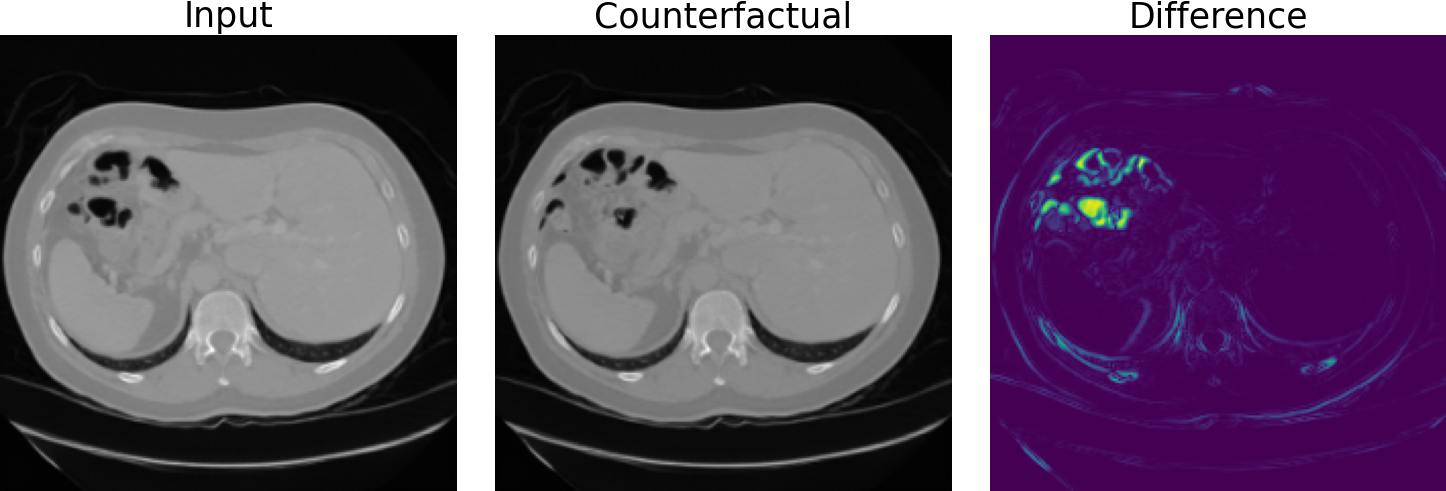

In [116]:
idx_slice = 120
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,:,idx_slice], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,:,idx_slice])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()

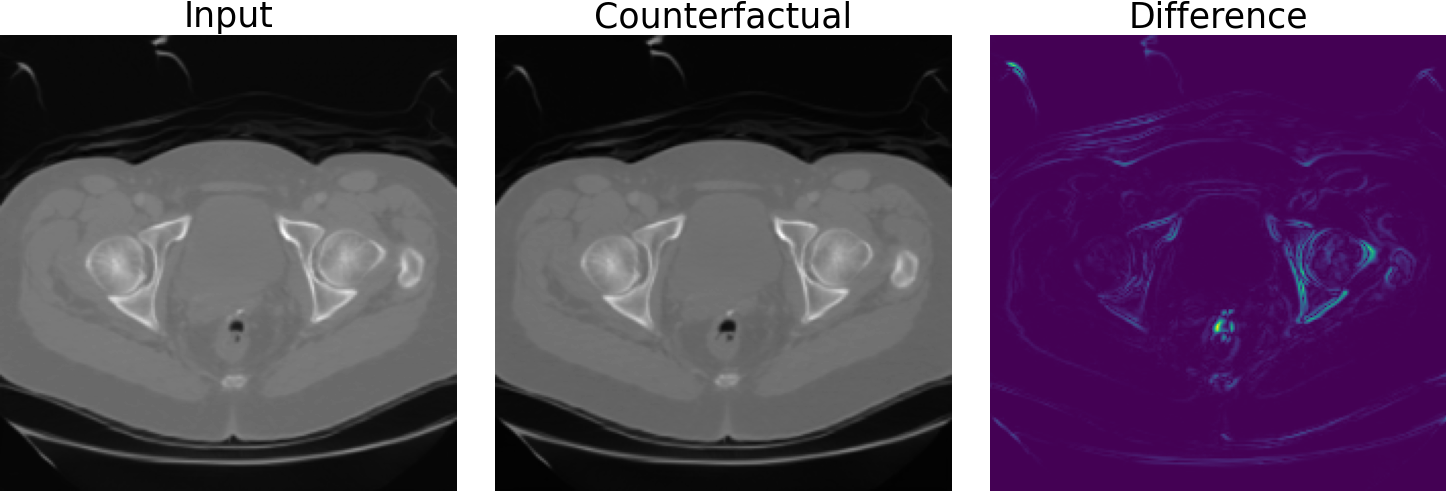

In [117]:
idx_slice = 25
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,:,idx_slice], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,:,idx_slice])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()

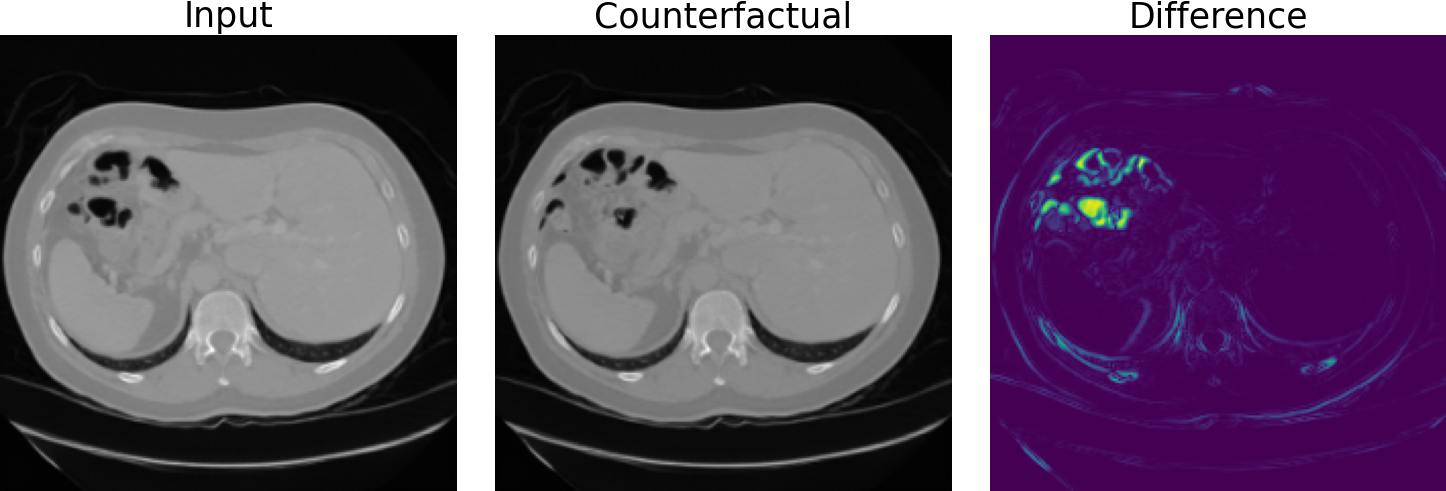

In [118]:
idx_slice = 120
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
axs[0].imshow(images_reconstruction[0][:,:,idx_slice], cmap='gray')
axs[0].set_title('Input', size=25)
axs[1].imshow(images_counterfactual[0][:,:,idx_slice], cmap='gray')
axs[1].set_title('Counterfactual', size=25)
axs[2].imshow(heatmaps1[0][:,:,idx_slice])
axs[2].set_title('Difference', size=25);
[axs[i].axis('off') for i in range(len(axs))]
plt.tight_layout()